In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
import catboost as cat
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from matplotlib import pyplot
import shap
import re

base_dir = 'data/'

import os
for dirname, _, filenames in os.walk(base_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.linear_model import LinearRegression
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from datetime import datetime
import gc
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 1000)

data/sample_submission.csv
data/reduce_test.csv
data/train_labels.csv
data/test.csv
data/data-science-bowl-2019.zip
data/reduce_train.csv
data/train.csv
data/specs.csv


# Objective

* In the last notebook we create our baseline model including a feature selection part. 
* Cohen cappa score of 0.456 (lb) with a local cv score of 0.529
* In this notebook we are going to add more features and remove others that i think they overfitt the train set and then check if our local cv score improve.
* Next, we will check if this improvement aligns with the lb.

# Notes
* Check the distribution of the target variable of the out of folds score and the prediction distribution. A good model should more or less have the same distribution.

In [2]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod(
            (datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [3]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv(base_dir + 'train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv(base_dir + 'test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv(base_dir + 'train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv(base_dir + 'specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv(base_dir + 'sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [4]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [5]:
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    user_activities_time = {'Clip_time_mean':[], 'Activity_time_mean': [], 'Game_time_mean': []}
    
    positive_words = "play again|did it|job|wow|cool|nice|amazing|exactly|Great|awe|That's it|just right|good|Alright|gold|That's right|All right|right amount|Well done|you're right|happy|won|Whoa"
    negative_words = "try again|too|Almost|n't|but|Whoops|Oops|not right|Uh oh"
    accumulated_positive_events = 0
    accumulated_negative_events = 0
    accumulated_positive_title = {'accumulated_positive_'+t: 0 for t in activity_game_titles}
    accumulated_negative_title = {'accumulated_negative_'+t: 0 for t in activity_game_titles}
    accumulated_positive_title_ratio = {'accumulated_positive_ratio_'+t: 0 for t in activity_game_titles}
    accumulated_negative_title_ratio = {'accumulated_negative_ratio_'+t: 0 for t in activity_game_titles}
    accumulated_won_game = {'accumulated_won_game_count_'+g: 0 for g in game_titles}
    
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {e_c: 0 for e_c in list_of_event_code}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()}
    title_event_code_count: Dict[str, int] = {t_e: 0 for t_e in all_title_event_code}
    accumulated_correct_title = {'accumulated_correct_'+title: 0 for title in assess_titles}
    accumulated_uncorrect_title = {'accumulated_uncorrect_'+title: 0 for title in assess_titles}
    accumulated_accuracy_title = {'acc_mean_' + title: 0 for title in assess_titles}
    accumulated_accuracy_titles = {'acc_' + title: [] for title in assess_titles}
    
    time_spent_each_act = {t+"_time": 0 for t in list_of_user_activities}
    time_spent_each_acts = {t+"_time": [] for t in list_of_user_activities}
    time_spent_each_act_mean = {t+"_time_mean": 0 for t in list_of_user_activities}
    
    
    # itarates through each session of one installation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
    
        if (session_type=='Clip'):
            time_spent = media_sequence[session_title_text]
            user_activities_time[session_type+'_time_mean'].append(time_spent)
            time_spent_each_act[session_title_text + "_time"] += time_spent
            time_spent_each_acts[session_title_text + "_time"].append(time_spent)
        
        elif(session_type=='Activity' or session_type=='Game'):
            time_spent = (session.iloc[-1, 2] - session.iloc[0, 2]).seconds
            user_activities_time[session_type+'_time_mean'].append(time_spent)
            time_spent_each_act[session_title_text + "_time"] += time_spent
            time_spent_each_acts[session_title_text + "_time"].append(time_spent)
            
            sum_positive_events = session['event_data'].str.contains(positive_words, flags=re.IGNORECASE).sum()
            sum_negative_events = session['event_data'].str.contains(negative_words, flags=re.IGNORECASE).sum()
            accumulated_positive_events += sum_positive_events
            accumulated_negative_events += sum_negative_events
            accumulated_positive_title['accumulated_positive_'+session_title_text] += sum_positive_events
            accumulated_negative_title['accumulated_negative_'+session_title_text] += sum_negative_events
            p = accumulated_positive_title['accumulated_positive_'+session_title_text]
            n = accumulated_negative_title['accumulated_negative_'+session_title_text]
            accumulated_positive_title_ratio['accumulated_positive__ratio_'+session_title_text] = p/(p+n) if (p+n)>0 else 0
            accumulated_negative_title_ratio['accumulated_negative__ratio_'+session_title_text] = n/(p+n) if (p+n)>0 else 0
            
            if session_type == 'Game':
                accumulated_won_game['accumulated_won_game_count_'+session_title_text]+=session['event_data'].str.contains('play again', flags=re.IGNORECASE).sum()
        
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(accumulated_correct_title.copy())
            features.update(accumulated_uncorrect_title.copy())
            features.update(accumulated_accuracy_title.copy())
            features.update(accumulated_positive_title)
            features.update(accumulated_negative_title)
            features.update(accumulated_positive_title_ratio)
            features.update(accumulated_negative_title_ratio)
            features.update(accumulated_won_game.copy())
            features.update(time_spent_each_act.copy())
            features.update(time_spent_each_act_mean.copy())
            
            variety_features = [('var_title', title_count),
                                ('var_event_code', event_code_count),
                               ('var_title_event_code', title_event_code_count)]
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
            
            # positive & negative events
            features['accumulated_positive_events'] = accumulated_positive_events
            features['accumulated_negative_events'] = accumulated_negative_events
            positive_negative_events = accumulated_positive_events + accumulated_negative_events
            features['positive_events_ratio'] = accumulated_positive_events/positive_negative_events if positive_negative_events > 0 else 0
            features['negative_events_ratio'] = accumulated_negative_events/positive_negative_events if positive_negative_events > 0 else 0
            accumulated_positive_events = 0
            accumulated_negative_events = 0
            
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_title['accumulated_correct_'+session_title_text] += true_attempts
            accumulated_uncorrect_title['accumulated_uncorrect_'+session_title_text] += false_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
                features['accumulated_correct_duration'] = 0
                features['accumulated_uncorrect_duration'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
                features['accumulated_correct_duration'] = features['accumulated_correct_attempts']/np.sum(durations)
                features['accumulated_uncorrect_duration'] = features['accumulated_uncorrect_attempts']/np.sum(durations)
            if user_activities_time['Clip_time_mean']==[]:
                features['Clip_time_mean'] = 0
                features['Clip_time_std'] = 0
            else:
                features['Clip_time_mean'] = np.mean(user_activities_time['Clip_time_mean'])
                features['Clip_time_std'] = np.std(user_activities_time['Clip_time_mean'])
            if user_activities_time['Activity_time_mean']==[]:
                features['Activity_time_mean'] = 0
                features['Activity_time_std'] = 0
            else:
                features['Activity_time_mean'] = np.mean(user_activities_time['Activity_time_mean'])
                features['Activity_time_std'] = np.std(user_activities_time['Activity_time_mean'])
            if user_activities_time['Game_time_mean']==[]:
                features['Game_time_mean'] = 0
                features['Game_time_std'] = 0
            else:
                features['Game_time_mean'] = np.mean(user_activities_time['Game_time_mean'])
                features['Game_time_std'] = np.std(user_activities_time['Game_time_mean'])
            time_spent = (session.iloc[-1, 2] - session.iloc[0, 2]).seconds
            time_spent_each_act[session_title_text + "_time"] += time_spent
            time_spent_each_acts[session_title_text + "_time"].append(time_spent)
            durations.append(time_spent)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            accumulated_accuracy_titles['acc_' + session_title_text].append(accuracy)
            if accumulated_accuracy_titles['acc_' + session_title_text]==[]:
                accumulated_accuracy_title['acc_mean_' + session_title_text] = 0
            else:
                accumulated_accuracy_title['acc_mean_' + session_title_text] = np.mean(accumulated_accuracy_titles['acc_' + session_title_text])
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
        
        event_code_count = update_counters(event_code_count, "event_code")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')
        
        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [6]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [7]:
def preprocess(reduce_train, reduce_test):
    for df in [reduce_train, reduce_test]:
        df['installation_session_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        #df['installation_duration_std'] = df.groupby(['installation_id'])['duration_mean'].transform('std')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')
        
        df['sum_event_code_count'] = df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]].sum(axis = 1)
        
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')
        #df['installation_event_code_count_std'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('std')
        
    features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
    features = [x for x in features if x not in ['accuracy_group', 'installation_id']] + ['acc_' + title for title in assess_titles]
   
    return reduce_train, reduce_test, features

In [8]:
activity_game_titles = ['All Star Sorting', 'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Air Show', 'Crystals Rule', 'Bug Measurer (Activity)', 'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Watering Hole (Activity)', 'Dino Drink', 'Bubble Bath', 'Bottle Filler (Activity)', 'Dino Dive', 'Chow Time', 'Chicken Balancer (Activity)', 'Happy Camel', 'Leaf Leader', 'Pan Balance', 'Egg Dropper (Activity)']
game_titles = ['All Star Sorting', 'Air Show', 'Crystals Rule', 'Scrub-A-Dub', 'Dino Drink', 'Bubble Bath', 'Dino Dive', 'Chow Time', 'Happy Camel', 'Leaf Leader', 'Pan Balance']
media_sequence = {'Welcome to Lost Lagoon!': 19, 'Tree Top City - Level 1':17, 'Ordering Spheres':61, 'Costume Box':61,'12 Monkeys':109, 'Tree Top City - Level 2':25, "Pirate's Tale":80, 
                  'Treasure Map':156, 'Tree Top City - Level 3':26, 'Rulers':126, 'Magma Peak - Level 1':20, 'Slop Problem':60, 'Magma Peak - Level 2':22, 'Crystal Caves - Level 1':18, 
                  'Balancing Act':72,'Lifting Heavy Things':118, 'Crystal Caves - Level 2':24, 'Honey Cake':142, 'Crystal Caves - Level 3':19, 'Heavy, Heavier, Heaviest':61}

数据处理-特征工程

In [9]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, \
list_of_event_code, activities_labels, assess_titles, list_of_event_id,\
all_title_event_code = encode_title(train, test, train_labels)
# tranform function to get the train and test set
if not os.path.exists(base_dir + 'reduce_train.csv'):
    reduce_train, reduce_test, categoricals = get_train_and_test(train, test)
    reduce_train.to_csv(base_dir + 'reduce_train.csv')
    reduce_test.to_csv(base_dir + 'reduce_test.csv')
    print(reduce_train.shape, reduce_test.shape, categoricals)
else:
    reduce_train = pd.read_csv(base_dir + 'reduce_train.csv')
    reduce_test = pd.read_csv(base_dir + 'reduce_test.csv')
    categoricals = ['session_title']

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


In [10]:
# call feature engineering function
# reduce_train, reduce_test, features = preprocess(reduce_train, reduce_test)

In [11]:
def stract_hists(feature, train=reduce_train, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre
# stract_hists('Magma Peak - Level 1_2000', adjust=True, plot=True)

In [12]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [13]:
counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
#             c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]   
            c = np.abs(np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1])  
            if c > 0.995:  # 相关性
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

1: FEAT_A: 2050 FEAT_B: 2040 - Correlation: 0.9965259434878118
2: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3121 - Correlation: 0.9999839030068793
3: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3021 - Correlation: 0.9998050146713992
4: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2030 - Correlation: 0.9966123918733654
5: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2040 - Correlation: 0.9965259434878118
6: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2050 - Correlation: 1.0
7: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2020 - Correlation: 0.9965084543995759
8: FEAT_A: 2050 FEAT_B: accumulated_positive_Scrub-A-Dub - Correlation: 0.9952342543487924
9: FEAT_A: 4230 FEAT_B: 4235 - Correlation: 0.9999995197498746
10: FEAT_A: 4230 FEAT_B: Bubble Bath_4230 - Correlation: 0.9999999999999998
11: FEAT_A: 4230 FEAT_B: Bubble Bath_4235 - Correlation: 0.9999995197498746
12: FEAT_A: 5000 FEAT_B: 5010 - Correlation: 0.9991849213605333
13: FEAT_A: 5000 FEAT_B: Watering Hole (Activity)_5010 - Correlation: 0.9991849213605333
14: FEAT_A: 5000 FEAT_B: Watering Hole (Act

96: FEAT_A: Bubble Bath_2030 FEAT_B: Bubble Bath_2035 - Correlation: 0.9991496470458585
97: FEAT_A: Bubble Bath_2030 FEAT_B: Bubble Bath_4020 - Correlation: 0.9962789226264855
98: FEAT_A: Bubble Bath_2030 FEAT_B: Bubble Bath_2025 - Correlation: 0.9964317167511039
99: FEAT_A: Cauldron Filler (Assessment)_3020 FEAT_B: Cauldron Filler (Assessment)_3120 - Correlation: 0.9998190477466209
100: FEAT_A: Chest Sorter (Assessment)_3021 FEAT_B: Chest Sorter (Assessment)_3121 - Correlation: 0.9985179906980775
101: FEAT_A: Chest Sorter (Assessment)_3021 FEAT_B: accumulated_correct_Chest Sorter (Assessment) - Correlation: 0.9996140232445475
102: FEAT_A: Watering Hole (Activity)_4025 FEAT_B: Watering Hole (Activity)_4020 - Correlation: 0.9991434495208743
103: FEAT_A: Crystals Rule_3120 FEAT_B: Crystals Rule_3020 - Correlation: 0.999835058794711
104: FEAT_A: Chest Sorter (Assessment)_3110 FEAT_B: Chest Sorter (Assessment)_3010 - Correlation: 0.9977337946782758
105: FEAT_A: Crystals Rule_3021 FEAT_B: C

In [14]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

Unnamed: 0 8844.5 499.5 7.11007774430553e-10
acc_Cart Balancer (Assessment) -0.04020325710970143 -0.47065833333333335 0.006732930476733109


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Bottle Filler (Activity)_2010 0.0 0.0
Sandcastle Builder (Activity)_2010 0.0 0.0


divide by zero encountered in double_scalars


Bubble Bath_4080 0.004070096099491238 0.0


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Chest Sorter (Assessment)_4080 0.012832108535895986 0.0
Happy Camel_4080 0.0008479366873940079 0.0


divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars


Cart Balancer (Assessment)_4080 0.007292255511588468 0.0
Scrub-A-Dub_4080 0.0 0.0
Dino Drink_4080 0.0009044657998869418 0.0


divide by zero encountered in double_scalars


Leaf Leader_4080 0.0004522328999434709 0.0


invalid value encountered in double_scalars
divide by zero encountered in double_scalars


Pan Balance_2010 0.0 0.0
Mushroom Sorter (Assessment)_4080 0.04392312040700961 0.0


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Egg Dropper (Activity)_4080 0.01978518937252685 0.0
Pan Balance_4080 0.0013001695873374789 0.0


invalid value encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Crystals Rule_2010 0.0 0.0
Fireworks (Activity)_4080 0.0013566986998304127 0.0
Bug Measurer (Activity)_4080 0.008988128886376484 0.0
Bubble Bath_4090 0.14703222159412097 0.008 0.0


invalid value encountered in double_scalars
divide by zero encountered in double_scalars


Air Show_4080 0.0 0.0
Watering Hole (Activity)_2010 0.0007348784624081402 0.0
Mushroom Sorter (Assessment)_4090 0.17382702091577162 0.008 0.0
Dino Dive_4080 0.0002826455624646693 0.0


divide by zero encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


accumulated_positive_Bug Measurer (Activity) 0.0 0.0
accumulated_positive_Watering Hole (Activity) 0.0 0.0
accumulated_positive_Egg Dropper (Activity) 0.0 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars


accumulated_positive_ratio_All Star Sorting 0.0 0.0
accumulated_positive_ratio_Fireworks (Activity) 0.0 0.0
accumulated_positive_ratio_Flower Waterer (Activity) 0.0 0.0
accumulated_positive_ratio_Air Show 0.0 0.0
accumulated_positive_ratio_Crystals Rule 0.0 0.0
accumulated_positive_ratio_Bug Measurer (Activity) 0.0 0.0
accumulated_positive_ratio_Sandcastle Builder (Activity) 0.0 0.0
accumulated_positive_ratio_Scrub-A-Dub 0.0 0.0
accumulated_positive_ratio_Watering Hole (Activity) 0.0 0.0
accumulated_positive_ratio_Dino Drink 0.0 0.0
accumulated_positive_ratio_Bubble Bath 0.0 0.0
accumulated_positive_ratio_Bottle Filler (Activity) 0.0 0.0
accumulated_positive_ratio_Dino Dive 0.0 0.0
accumulated_positive_ratio_Chow Time 0.0 0.0
accumulated_positive_ratio_Chicken Balancer (Activity) 0.0 0.0
accumulated_positive_ratio_Happy Camel 0.0 0.0
accumulated_positive_ratio_Leaf Leader 0.0 0.0
accumulated_positive_ratio_Pan Balance 0.0 0.0
accumulated_positive_ratio_Egg Dropper (Activity) 0.0 0.0
ac

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Chest Sorter (Assessment)_time 452.7551158846806 36.574 0.007628145048781528


invalid value encountered in double_scalars


Chicken Balancer (Activity)_time_mean 0.0 0.0
Sandcastle Builder (Activity)_time_mean 0.0 0.0
Dino Dive_time_mean 0.0 0.0
Cauldron Filler (Assessment)_time_mean 0.0 0.0
Bird Measurer (Assessment)_time_mean 0.0 0.0
Scrub-A-Dub_time_mean 0.0 0.0
Slop Problem_time_mean 0.0 0.0
Crystals Rule_time_mean 0.0 0.0
Welcome to Lost Lagoon!_time_mean 0.0 0.0
Cart Balancer (Assessment)_time_mean 0.0 0.0
Air Show_time_mean 0.0 0.0
Ordering Spheres_time_mean 0.0 0.0
Tree Top City - Level 1_time_mean 0.0 0.0
Tree Top City - Level 2_time_mean 0.0 0.0
Chest Sorter (Assessment)_time_mean 0.0 0.0
Heavy, Heavier, Heaviest_time_mean 0.0 0.0
Balancing Act_time_mean 0.0 0.0
Honey Cake_time_mean 0.0 0.0
Pirate's Tale_time_mean 0.0 0.0
Magma Peak - Level 2_time_mean 0.0 0.0
Happy Camel_time_mean 0.0 0.0
Mushroom Sorter (Assessment)_time_mean 0.0 0.0
Dino Drink_time_mean 0.0 0.0
Lifting Heavy Things_time_mean 0.0 0.0
Rulers_time_mean 0.0 0.0
Chow Time_time_mean 0.0 0.0
12 Monkeys_time_mean 0.0 0.0
Costume Box_ti

invalid value encountered in double_scalars


In [15]:
features = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features].shape, ajusted_test.shape, len(features), categoricals

((17690, 430), (1000, 756), 430, ['session_title'])

In [16]:
reduce_train.shape, reduce_test.shape, len(features)

((17690, 756), (1000, 756), 430)

贝叶斯优化

------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | baggin... | colsam... | lambda_l1 | lambda_l2 | learni... | max_depth |
-------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.948592	valid_1's rmse: 1.01121
[200]	training's rmse: 0.885196	valid_1's rmse: 0.995572
[300]	training's rmse: 0.844333	valid_1's rmse: 0.994777
[400]	training's rmse: 0.809955	valid_1's rmse: 0.994516
[500]	training's rmse: 0.779878	valid_1's rmse: 0.995543
Early stopping, best iteration is:
[368]	training's rmse: 0.820456	valid_1's rmse: 0.994293
Partial score of fold 0 is: 0.5757464431216828
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.949057	valid_1's rmse: 1.00703
[200]	training's rmse: 0.886141	valid_1's rmse: 0.

[100]	training's rmse: 0.881048	valid_1's rmse: 0.984343
[200]	training's rmse: 0.804426	valid_1's rmse: 0.983968
Early stopping, best iteration is:
[140]	training's rmse: 0.847255	valid_1's rmse: 0.983034
Partial score of fold 4 is: 0.593807586040725
|  4        |  0.591    |  0.9439   |  1.394    |  0.5501   |  0.02768  |  0.6697   |  0.05611  |  8.078    |
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.845309	valid_1's rmse: 0.998156
[200]	training's rmse: 0.761237	valid_1's rmse: 1.0035
Early stopping, best iteration is:
[98]	training's rmse: 0.847359	valid_1's rmse: 0.997749
Partial score of fold 0 is: 0.5752096398021403
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.846984	valid_1's rmse: 0.990366
[200]	training's rmse: 0.764688	valid_1's rmse: 0.995951
Early stopping, best iteration is:
[103]	training's rmse: 0.843608	valid_1's rmse: 0.9902
Partial score of fold 1 is: 0.5934609526665808
Training unti

[100]	training's rmse: 0.900495	valid_1's rmse: 0.986897
[200]	training's rmse: 0.837715	valid_1's rmse: 0.985995
[300]	training's rmse: 0.79167	valid_1's rmse: 0.988829
Early stopping, best iteration is:
[188]	training's rmse: 0.844001	valid_1's rmse: 0.985834
Partial score of fold 4 is: 0.5952394165371666
|  8        |  0.5943   |  0.4546   |  1.067    |  0.5944   |  5.931    |  0.01886  |  0.05494  |  11.64    |
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.921362	valid_1's rmse: 1.00085
[200]	training's rmse: 0.86373	valid_1's rmse: 0.997289
[300]	training's rmse: 0.821971	valid_1's rmse: 1.00162
Early stopping, best iteration is:
[166]	training's rmse: 0.880506	valid_1's rmse: 0.996346
Partial score of fold 0 is: 0.5757464431216828
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.921898	valid_1's rmse: 0.993589
[200]	training's rmse: 0.864721	valid_1's rmse: 0.987146
[300]	training's rmse: 0.822881	vali

Early stopping, best iteration is:
[298]	training's rmse: 0.781736	valid_1's rmse: 0.970474
Partial score of fold 3 is: 0.6072389045348349
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.895905	valid_1's rmse: 0.986733
[200]	training's rmse: 0.828668	valid_1's rmse: 0.984637
[300]	training's rmse: 0.778495	valid_1's rmse: 0.985804
Early stopping, best iteration is:
[165]	training's rmse: 0.849185	valid_1's rmse: 0.98373
Partial score of fold 4 is: 0.592912691980449
|  12       |  0.5944   |  0.8299   |  9.625    |  0.4309   |  5.92     |  5.987    |  0.06005  |  11.96    |
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.869696	valid_1's rmse: 0.995364
[200]	training's rmse: 0.792022	valid_1's rmse: 0.999507
Early stopping, best iteration is:
[99]	training's rmse: 0.870678	valid_1's rmse: 0.995157
Partial score of fold 0 is: 0.5764621808810726
Training until validation scores don't improve for 150 rounds
[100]

[100]	training's rmse: 0.901162	valid_1's rmse: 0.974672
[200]	training's rmse: 0.835884	valid_1's rmse: 0.970206
[300]	training's rmse: 0.787951	valid_1's rmse: 0.970847
Early stopping, best iteration is:
[189]	training's rmse: 0.842148	valid_1's rmse: 0.969654
Partial score of fold 3 is: 0.6090282489333094
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.899078	valid_1's rmse: 0.986811
[200]	training's rmse: 0.834293	valid_1's rmse: 0.981963
[300]	training's rmse: 0.785323	valid_1's rmse: 0.984138
Early stopping, best iteration is:
[214]	training's rmse: 0.826862	valid_1's rmse: 0.981281
Partial score of fold 4 is: 0.5895120945514003
|  16       |  0.5954   |  0.6785   |  9.861    |  0.546    |  5.995    |  5.908    |  0.05742  |  11.99    |
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.861641	valid_1's rmse: 1.00267
[200]	training's rmse: 0.785373	valid_1's rmse: 1.01359
Early stopping, best iteration is:

Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.967582	valid_1's rmse: 1.01114
[200]	training's rmse: 0.906904	valid_1's rmse: 0.98642
[300]	training's rmse: 0.868953	valid_1's rmse: 0.980192
[400]	training's rmse: 0.838356	valid_1's rmse: 0.97823
[500]	training's rmse: 0.812412	valid_1's rmse: 0.977847
[600]	training's rmse: 0.789465	valid_1's rmse: 0.978078
Early stopping, best iteration is:
[490]	training's rmse: 0.814741	valid_1's rmse: 0.977602
Partial score of fold 2 is: 0.6054495601363603
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.964639	valid_1's rmse: 1.00224
[200]	training's rmse: 0.906716	valid_1's rmse: 0.978555
[300]	training's rmse: 0.86943	valid_1's rmse: 0.971801
[400]	training's rmse: 0.838855	valid_1's rmse: 0.969372
[500]	training's rmse: 0.812836	valid_1's rmse: 0.968492
[600]	training's rmse: 0.790216	valid_1's rmse: 0.96833
Early stopping, best iteration is:
[529]	training's rmse: 0

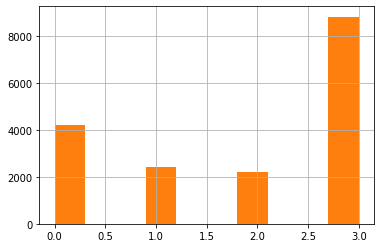

In [18]:
# solve: LightGBMError: Do not support special JSON characters in feature name.
reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
ajusted_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in ajusted_test.columns]
features = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features]


def LGB_CV(
          max_depth,
          learning_rate,
          bagging_freq,
          bagging_fraction,
          colsample_bytree,
#           feature_fraction,
          lambda_l1,
          lambda_l2,
          target='accuracy_group',
          categoricals=['session_title']
         ):
    train_df = reduce_train

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
#     folds = GroupKFold(n_splits=5)
    
    cv = folds.split(reduce_train, reduce_train[target])
    
    param = {
        'objective':'regression',
        "boosting_type": "gbdt",
        'metric': 'rmse',
        'eval_metric': 'cappa',
        "bagging_seed": 11,
        "metric": 'rmse',
        'early_stopping_rounds': 150,
        'verbose': 100,
        "verbosity": -1,
        'seed': 42,
        'bagging_freq': int(bagging_freq),
        'colsample_bytree': colsample_bytree,
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
#         "feature_fraction": feature_fraction,
        "bagging_fraction": bagging_fraction,
        "lambda_l1": lambda_l1,
        "lambda_l2": lambda_l2,
    }
    
    
    oof_pred = np.zeros(train_df.shape[0])
    for fold, (train_idx, val_idx) in enumerate(cv):
        
        x_train, x_val = train_df[features].iloc[train_idx], train_df[features].iloc[val_idx]   
        y_train, y_val = train_df[target][train_idx], train_df[target][val_idx]

        train_set = lgb.Dataset(x_train, y_train, categorical_feature=categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=categoricals)
        
        clf = lgb.train(param, train_set, 10000, valid_sets = [train_set, val_set], verbose_eval=100, early_stopping_rounds=100)
        
        oof_pred[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
        
        print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        
        del clf, train_idx, val_idx
        gc.collect()
    _, loss_score, _ = eval_qwk_lgb_regr(train_df[target], oof_pred)    
#     return -mean_squared_error(oof, target)**0.5
    return loss_score

LGB_BO = BayesianOptimization(LGB_CV, {
    'max_depth': (8, 12),
#     'feature_fraction': (0.4, 1.0),
    'bagging_freq': (1, 10),
    'bagging_fraction': (0.4, 1.0),
    'lambda_l1': (0, 6),
    'lambda_l2': (0, 6),
    'learning_rate': (0.025, 0.1),
    'colsample_bytree': (0.4, 0.6)
    })

print('-'*126)

start_time = timer(None)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0, random_state=1000)
timer(start_time)

In [19]:
print('-'*130)
print('Final Results')
print('Maximum  value: %f' % LGB_BO.max['target'])
print('Best  parameters:', LGB_BO.max['params'])

if LGB_BO.max['target'] > 0.596892:
    LGB_pramas = LGB_BO.max['params']
else:
    LGB_pramas = {
    'bagging_fraction': 0.5703482080116283, 
    'bagging_freq': 1.1066058349920214,
    'colsample_bytree': 0.5515000831403941,
    'lambda_l1': 5.8079230594147,
    'lambda_l2': 5.988476114292218, 
    'learning_rate': 0.02606739709720534,
    'max_depth': 8.184768586407403}

# Maximum  value: 0.596892
# Best  parameters: {
#     'bagging_fraction': 0.5703482080116283, 
#     'bagging_freq': 1.1066058349920214,
#     'colsample_bytree': 0.5515000831403941,
#     'lambda_l1': 5.8079230594147,
#     'lambda_l2': 5.988476114292218, 
#     'learning_rate': 0.02606739709720534,
#     'max_depth': 8.184768586407403}

----------------------------------------------------------------------------------------------------------------------------------
Final Results
Maximum  value: 0.596033
Best  parameters: {'bagging_fraction': 0.9376126661710961, 'bagging_freq': 1.0122432747847445, 'colsample_bytree': 0.4046359581087421, 'lambda_l1': 5.649459684691463, 'lambda_l2': 4.7513758395470145, 'learning_rate': 0.026591540142749785, 'max_depth': 11.020281856920317}


|   iter    |  target   | colsam... |   gamma   | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
[0]	train-rmse:1.76336	val-rmse:1.76322
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.0103	val-rmse:1.02962
[200]	train-rmse:0.983709	val-rmse:1.02088
[300]	train-rmse:0.966443	val-rmse:1.01688
[400]	train-rmse:0.953895	val-rmse:1.0166
Stopping. Best iteration:
[366]	train-rmse:0.957936	val-rmse:1.01597

Partial score of fold 0 is: 0.5589266057760218
[0]	train-rmse:1.76305	val-rmse:1.76448
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.01258	val-rmse:1.03527
[200]	train-rmse:0.984468	val-rmse:1.01945
[300]	train-rmse:0.969145	val-rmse:1.01625
[400]	train-rmse:0.955563	

[0]	train-rmse:1.73732	val-rmse:1.74412
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.717288	val-rmse:0.979681
[200]	train-rmse:0.681716	val-rmse:0.979282
Stopping. Best iteration:
[187]	train-rmse:0.685944	val-rmse:0.978686

Partial score of fold 3 is: 0.5966817725838349
[0]	train-rmse:1.73752	val-rmse:1.74186
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.719255	val-rmse:0.9919
Stopping. Best iteration:
[58]	train-rmse:0.75089	val-rmse:0.990203

Partial score of fold 4 is: 0.5918388191081179
|  4        |  0.5846   |  0.6906   |  5.524    |  0.03203  |  11.81    |  19.86    |  0.6429   |
[0]	train-rmse:1.76334	val-rmse:1.763
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 ro

Partial score of fold 0 is: 0.5669786555691574
[0]	train-rmse:1.74173	val-rmse:1.74789
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.681454	val-rmse:1.01972
Stopping. Best iteration:
[39]	train-rmse:0.798434	val-rmse:1.01087

Partial score of fold 1 is: 0.5627670158274449
[0]	train-rmse:1.73893	val-rmse:1.74413
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.691108	val-rmse:1.01524
Stopping. Best iteration:
[37]	train-rmse:0.817735	val-rmse:1.00646

Partial score of fold 2 is: 0.568410131087937
[0]	train-rmse:1.74085	val-rmse:1.74531
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.68824	val-rmse:0.996287
Stopping. Best iteration:
[60]	train-rmse:0.761

[300]	train-rmse:0.816191	val-rmse:0.989588
Stopping. Best iteration:
[236]	train-rmse:0.822683	val-rmse:0.988653

Partial score of fold 3 is: 0.5870193128320724
[0]	train-rmse:1.74076	val-rmse:1.74473
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.850579	val-rmse:0.9954
[200]	train-rmse:0.828334	val-rmse:0.99562
[300]	train-rmse:0.815227	val-rmse:0.996353
Stopping. Best iteration:
[209]	train-rmse:0.826288	val-rmse:0.99508

Partial score of fold 4 is: 0.5809211115727507
|  10       |  0.5838   |  0.4445   |  9.8      |  0.8439   |  11.86    |  14.49    |  0.4386   |
[0]	train-rmse:1.72906	val-rmse:1.74155
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.703802	val-rmse:1.00081
Stopping. Best iteration:
[59]	train-rmse:0.718198	val-rmse:0.999698

Partial score of 

[100]	train-rmse:0.842771	val-rmse:0.979684
[200]	train-rmse:0.8188	val-rmse:0.978469
[300]	train-rmse:0.810387	val-rmse:0.978025
[400]	train-rmse:0.804933	val-rmse:0.977863
Stopping. Best iteration:
[388]	train-rmse:0.80533	val-rmse:0.977671

Partial score of fold 3 is: 0.6018708713394112
[0]	train-rmse:1.74318	val-rmse:1.74405
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.846361	val-rmse:0.978988
[200]	train-rmse:0.823639	val-rmse:0.979262
Stopping. Best iteration:
[120]	train-rmse:0.836847	val-rmse:0.978582

Partial score of fold 4 is: 0.5984610351541602
|  14       |  0.5944   |  0.414    |  6.816    |  3.032    |  6.469    |  5.67     |  0.9945   |
[0]	train-rmse:1.73763	val-rmse:1.74387
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.845775	val-rmse:0.9909

[0]	train-rmse:1.74005	val-rmse:1.74371
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.849168	val-rmse:0.983409
[200]	train-rmse:0.83279	val-rmse:0.983212
Stopping. Best iteration:
[185]	train-rmse:0.835861	val-rmse:0.982939

Partial score of fold 2 is: 0.6015130024597163
[0]	train-rmse:1.74029	val-rmse:1.74351
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.850962	val-rmse:0.977865
[200]	train-rmse:0.836262	val-rmse:0.976193
[300]	train-rmse:0.831612	val-rmse:0.975653
Stopping. Best iteration:
[234]	train-rmse:0.833473	val-rmse:0.975503

Partial score of fold 3 is: 0.5941766904259707
[0]	train-rmse:1.74027	val-rmse:1.74213
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.880486	val-rmse:0.991162
[200]	train-rmse:0.865318	val-rmse:0.990895
[300]	train-rmse:0.858501	val-rmse:0.991049
Stopping. Best iteration:
[252]	train-rmse:0.860743	val-rmse:0.990499

Partial score of fold 0 is: 0.5850510339937505
[0]	train-rmse:1.7444	val-rmse:1.74655
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.878575	val-rmse:0.990812
[200]	train-rmse:0.86294	val-rmse:0.98902
[300]	train-rmse:0.855295	val-rmse:0.98893
[400]	train-rmse:0.849789	val-rmse:0.987839
[500]	train-rmse:0.845893	val-rmse:0.987592
Stopping. Best iteration:
[467]	train-rmse:0.846394	val-rmse:0.98756

Partial score of fold 1 is: 0.59703964146353
[0]	train-rmse:1.74261	val-rmse:1.74522
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds

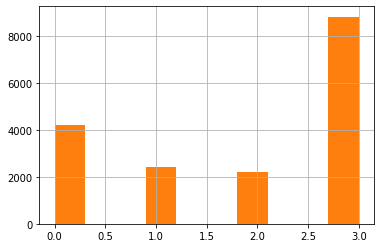

In [20]:
# Comment out any parameter you don't want to test
def XGB_CV(
          max_depth,
          gamma,
          min_child_weight,
          max_delta_step,
          subsample,
          colsample_bytree,
          target='accuracy_group',
          verbosity=100
         ):

    train_df = reduce_train

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
    
    cv = folds.split(reduce_train, reduce_train[target])
    
    params = {
      'booster' : 'gbtree',
      'max_depth' : int(max_depth),
      'gamma' : gamma,
      'eta' : 0.1,
      'nthread' : 4,
      'silent' : True,
#       'eval_metric': 'auc',
      'subsample' : max(min(subsample, 1), 0),
      'colsample_bytree' : max(min(colsample_bytree, 1), 0),
      'min_child_weight' : min_child_weight,
      'max_delta_step' : int(max_delta_step),
      'seed' : 1001,
      'objective':'reg:squarederror',
    }
    
    
    oof_pred = np.zeros(train_df.shape[0])
    for fold, (train_idx, val_idx) in enumerate(cv):
        
        x_train, x_val = train_df[features].iloc[train_idx], train_df[features].iloc[val_idx]   
        y_train, y_val = train_df[target][train_idx], train_df[target][val_idx]

        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        
        clf = xgb.train(params, 
                         train_set, 
                         num_boost_round=5000, 
                         evals=[(train_set, 'train'), 
                                (val_set, 'val')], 
                         verbose_eval=verbosity,
                         early_stopping_rounds=100)
        
        oof_pred[val_idx] = clf.predict(xgb.DMatrix(train_df.iloc[val_idx][features]))

        print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        
        del clf, train_idx, val_idx
        gc.collect()
    _, loss_score, _ = eval_qwk_lgb_regr(train_df[target], oof_pred)    
#     return -mean_squared_error(oof, target)**0.5
    return loss_score

    
XGB_BO = BayesianOptimization(XGB_CV, {
                                     'max_depth': (2, 12),
                                     'gamma': (0.001, 10.0),
                                     'min_child_weight': (0, 20),
                                     'max_delta_step': (0, 10),
                                     'subsample': (0.4, 1.0),
                                     'colsample_bytree' :(0.4, 1.0)
                                    })

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    XGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)

In [22]:
print('-'*130)
print('Final Results')
print('Maximum  value: %f' % XGB_BO.max['target'])
print('Best  parameters:', XGB_BO.max['params'])



if XGB_BO.max['target'] > 0.592347:
    XGB_params = XGB_BO.max['params']
else:
    XGB_params = {
    'colsample_bytree': 0.5718422563102614,
    'gamma': 9.121035497281943,
    'max_delta_step': 1.070668157937703, 
    'max_depth': 8.29419083806185, 
    'min_child_weight': 0.6493316414338923,
    'subsample': 0.6592648167510096}
    
# Maximum  value: 0.592347   # 0.538
# Best  parameters: {
#     'colsample_bytree': 0.5718422563102614,
#     'gamma': 9.121035497281943,
#     'max_delta_step': 1.070668157937703, 
#     'max_depth': 8.29419083806185, 
#     'min_child_weight': 0.6493316414338923,
#     'subsample': 0.6592648167510096}

----------------------------------------------------------------------------------------------------------------------------------
Final Results
Maximum  value: 0.594995
Best  parameters: {'colsample_bytree': 0.4111093981137389, 'gamma': 9.69438381393494, 'max_delta_step': 7.343152194270375, 'max_depth': 8.846656726149618, 'min_child_weight': 11.860020745901581, 'subsample': 0.9924094209834936}


|   iter    |  target   | colsam... |   depth   | l2_lea... | learni... |
-------------------------------------------------------------------------
0:	learn: 1.2514921	test: 1.2519099	best: 1.2519099 (0)	total: 1.88s	remaining: 1h 2m 43s
100:	learn: 1.0239308	test: 1.0593876	best: 1.0593876 (100)	total: 33.8s	remaining: 10m 34s
200:	learn: 0.9586329	test: 1.0268921	best: 1.0268921 (200)	total: 59.1s	remaining: 8m 48s
300:	learn: 0.9180532	test: 1.0149621	best: 1.0149621 (300)	total: 2m 58s	remaining: 16m 49s
400:	learn: 0.8871151	test: 1.0096452	best: 1.0096452 (400)	total: 5m 10s	remaining: 20m 39s
500:	learn: 0.8622772	test: 1.0065988	best: 1.0065988 (500)	total: 5m 35s	remaining: 16m 43s
600:	learn: 0.8364303	test: 1.0041980	best: 1.0041980 (600)	total: 7m 22s	remaining: 17m 10s
700:	learn: 0.8119431	test: 1.0027296	best: 1.0027296 (700)	total: 9m 35s	remaining: 17m 45s
800:	learn: 0.7902624	test: 1.0018017	best: 1.0017925 (794)	total: 10m 28s	remaining: 15m 41s
900:	learn: 0.772887

Partial score of fold 1 is: 0.5931030837868858
0:	learn: 1.2267653	test: 1.2277444	best: 1.2277444 (0)	total: 366ms	remaining: 12m 12s
100:	learn: 0.9283270	test: 0.9936091	best: 0.9936091 (100)	total: 34.5s	remaining: 10m 49s
200:	learn: 0.8657341	test: 0.9853033	best: 0.9853033 (200)	total: 40.9s	remaining: 6m 6s
300:	learn: 0.8224689	test: 0.9842994	best: 0.9835756 (274)	total: 47.3s	remaining: 4m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9835755562
bestIteration = 274

Shrink model to first 275 iterations.
Partial score of fold 2 is: 0.6013340680198689
0:	learn: 1.2291744	test: 1.2283314	best: 1.2283314 (0)	total: 69.6ms	remaining: 2m 19s
100:	learn: 0.9338900	test: 0.9881510	best: 0.9881510 (100)	total: 6.89s	remaining: 2m 9s
200:	learn: 0.8750340	test: 0.9816720	best: 0.9814473 (194)	total: 26s	remaining: 3m 53s
300:	learn: 0.8288734	test: 0.9799607	best: 0.9795620 (264)	total: 1m 3s	remaining: 5m 59s
Stopped by overfitting detector  (100 iterations

KeyboardInterrupt: 

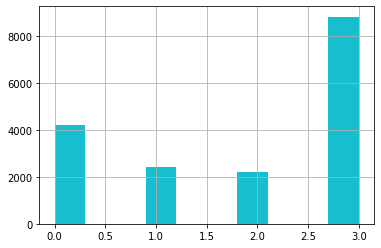

In [24]:
def Cat_CV(
        depth,
        colsample_bylevel,
        l2_leaf_reg,
        learning_rate,
        target='accuracy_group',
        verbosity=100
        ):

    train_df = reduce_train

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
    
    cv = folds.split(reduce_train, reduce_train[target])
    
    params = {        
        'loss_function': 'RMSE',
        'task_type': "CPU",
        'early_stopping_rounds': 100,
        'random_seed': 42,
        'use_best_model': True,
        'depth': int(depth),
        'colsample_bylevel': colsample_bylevel, 
        'l2_leaf_reg': l2_leaf_reg,
        'learning_rate': learning_rate,
        'iterations': 2000,
    }
    
    
    oof_pred = np.zeros(train_df.shape[0])
    for fold, (train_idx, val_idx) in enumerate(cv):
        
        x_train, x_val = train_df[features].iloc[train_idx], train_df[features].iloc[val_idx]   
        y_train, y_val = train_df[target][train_idx], train_df[target][val_idx]
        
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        
        clf = CatBoostRegressor(**params)
        clf.fit(x_train, 
                y_train, 
                eval_set=(x_val, y_val),
                verbose=verbosity, 
                cat_features=categoricals)
        
        oof_pred[val_idx] = clf.predict(x_val)

        print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        
        del clf, train_idx, val_idx
        gc.collect()
    _, loss_score, _ = eval_qwk_lgb_regr(train_df[target], oof_pred)    
    return loss_score

    
Cat_BO = BayesianOptimization(Cat_CV, {
                                    'depth': (5, 15),
                                    'colsample_bylevel': (0.4, 1.0), 
                                    'l2_leaf_reg': (10,30),
                                    'learning_rate': (0.001, 0.1)
                                    })

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    Cat_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)

In [25]:
print('-'*130)
print('Final Results')
print('Maximum  value: %f' % Cat_BO.max['target'])
print('Best  parameters:', Cat_BO.max['params'])

# if Cat_BO.max['target'] > 0.592347:
#     Cat_params = Cat_BO.max['params']
# else:
#     Cat_params = {
#     'colsample_bytree': 0.5718422563102614,
#     'gamma': 9.121035497281943,
#     'max_delta_step': 1.070668157937703, 
#     'max_depth': 8.29419083806185, 
#     'min_child_weight': 0.6493316414338923,
#     'subsample': 0.6592648167510096}

----------------------------------------------------------------------------------------------------------------------------------
Final Results
Maximum  value: 0.589770
Best  parameters: {'colsample_bylevel': 0.534114552720876, 'depth': 12.44054131316808, 'l2_leaf_reg': 14.105716886084672, 'learning_rate': 0.01644000264211051}


模型

In [26]:
class Base_Model(object):
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True, params=None):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params(params)
        self.y_pred, self.oof_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
#         cv = GroupKFold(n_splits=self.n_splits)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self, params):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            # 相当于降维
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]   
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            # 针对不同模型处理数据
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            # 针对不同模型训练数据
            model = self.train_model(train_set, val_set) 
            # 得到验证数据的预测值
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            # 得到测试数据的预测值
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, oof_pred, loss_score, model

In [27]:
class Lgb_Model(Base_Model):
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self, params=None):
        if params is None :
            default_params = {
                'n_estimators':2000,
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': 'rmse',
                'n_jobs': -1,
                'eval_metric': 'cappa',
                'subsample': 0.75,
                'subsample_freq': 1,
                'learning_rate': 0.01,
                'feature_fraction': 0.9,
                'max_depth': 15,
                'lambda_l1': 1,  
                'lambda_l2': 1,
                'early_stopping_rounds': 100}
        else:
            default_params = {
                "bagging_seed": 11,
                'verbose': 100,
                "verbosity": -1,
                'seed': 42,
                'n_estimators':2000,
                'subsample': 0.75,
                'subsample_freq': 1,
                'n_jobs': -1,
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': 'rmse',
                'early_stopping_rounds': 100,
                'eval_metric': 'cappa',
                'learning_rate': params['learning_rate'],
#                 'feature_fraction': params['feature_fraction'],
                'colsample_bytree': params['colsample_bytree'], 
                'bagging_fraction': params['bagging_fraction'],
                'bagging_freq': int(params['bagging_freq']),
                'max_depth': int(params['max_depth']),
                'lambda_l1': params['lambda_l1'],  
                'lambda_l2': params['lambda_l2']}
        return default_params

In [28]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, 
                         train_set, 
                         num_boost_round=5000, 
                         evals=[(train_set, 'train'), 
                                (val_set, 'val')], 
                         verbose_eval=verbosity,
                         early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self, params=None):
        if params is None :
            default_params = {
                      'colsample_bytree': 0.8,                 
                      'learning_rate': 0.01,
                      'max_depth': 10,
                      'subsample': 1,
                      'objective':'reg:squarederror',
                      #'eval_metric':'rmse',
                      'min_child_weight':3,
                      'gamma':0.25,
                      'n_estimators':2000}
        else:
            default_params = {
                  'colsample_bytree': params['colsample_bytree'],                 
                  'learning_rate': 0.01,
                  'max_depth': int(params['max_depth']),
                  'subsample': params['subsample'],
                  'objective':'reg:squarederror',
                  #'eval_metric':'rmse',
                  'min_child_weight':params['min_child_weight'],
                  'gamma': params['gamma'],
                  'n_estimators':2000,
                  'max_delta_step': params['max_delta_step']}
        return default_params

In [29]:
class Catb_Model(Base_Model):
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        clf = CatBoostRegressor(**self.params)
        clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=(val_set['X'], val_set['y']),
                verbose=verbosity, 
                cat_features=self.categoricals)
        return clf
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self, params=None):
        if params is None :
            default_params = {
                    'loss_function': 'RMSE',
                    'task_type': "CPU",
                    'iterations': 2000,
                    'od_type': "Iter",
                    'depth': 10,
                    'colsample_bylevel': 0.5, 
                    'early_stopping_rounds': 300,
                    'l2_leaf_reg': 18,
                    'random_seed': 42,
                    'use_best_model': True}
        else:
            default_params = {
                    'loss_function': 'RMSE',
                    'task_type': "CPU",
                    'iterations': 2000,
                    'od_type': "Iter",
                    'depth': int(params['depth']),
                    'early_stopping_rounds': 300,
                    'colsample_bylevel': params['min_child_weight'], 
                    'l2_leaf_reg': params['l2_leaf_reg'],
                    'learning_rate': parmas['learning_rate'],
                    'random_seed': 42,
                    'use_best_model': True}
        return default_params

In [30]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

class Nn_Model(Base_Model):
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        print(train_df[features].shape)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set['X'].shape[1],)),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='relu')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [31]:
from random import choice

class Cnn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        self.create_feat_2d(features)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def create_feat_2d(self, features, n_feats_repeat=50):
        self.n_feats = len(features)
        self.n_feats_repeat = n_feats_repeat
        self.mask = np.zeros((self.n_feats_repeat, self.n_feats), dtype=np.int32)
        for i in range(self.n_feats_repeat):
            l = list(range(self.n_feats))
            for j in range(self.n_feats):
                c = l.pop(choice(range(len(l))))
                self.mask[i, j] = c
        self.mask = tf.convert_to_tensor(self.mask)
        print(self.mask.shape)
       
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0

        inp = tf.keras.layers.Input(shape=(self.n_feats))
        x = tf.keras.layers.Lambda(lambda x: tf.gather(x, self.mask, axis=1))(inp)
        x = tf.keras.layers.Reshape((self.n_feats_repeat, self.n_feats, 1))(x)
        x = tf.keras.layers.Conv2D(18, (50, 50), strides=50, activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        #x = tf.keras.layers.Dense(200, activation='relu')(x)
        #x = tf.keras.layers.LayerNormalization()(x)
        #x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(100, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(50, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        out = tf.keras.layers.Dense(1)(x)
        
        model = tf.keras.Model(inp, out)
    
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

0:	learn: 1.2466972	test: 1.2472652	best: 1.2472652 (0)	total: 228ms	remaining: 7m 35s
100:	learn: 0.9868761	test: 1.0291019	best: 1.0291019 (100)	total: 9.05s	remaining: 2m 50s
200:	learn: 0.9401990	test: 1.0103550	best: 1.0103550 (200)	total: 17.1s	remaining: 2m 33s
300:	learn: 0.9073364	test: 1.0036652	best: 1.0036652 (300)	total: 25.6s	remaining: 2m 24s
400:	learn: 0.8743469	test: 0.9994654	best: 0.9994152 (398)	total: 33.7s	remaining: 2m 14s
500:	learn: 0.8497647	test: 0.9975701	best: 0.9975701 (500)	total: 41s	remaining: 2m 2s
600:	learn: 0.8289466	test: 0.9969782	best: 0.9967539 (589)	total: 48.4s	remaining: 1m 52s
700:	learn: 0.8113833	test: 0.9969201	best: 0.9967539 (589)	total: 56.5s	remaining: 1m 44s
800:	learn: 0.7925582	test: 0.9966511	best: 0.9966210 (789)	total: 1m 3s	remaining: 1m 35s
900:	learn: 0.7745141	test: 0.9963527	best: 0.9962399 (889)	total: 1m 11s	remaining: 1m 27s
1000:	learn: 0.7580732	test: 0.9961782	best: 0.9960776 (951)	total: 1m 19s	remaining: 1m 19s
110

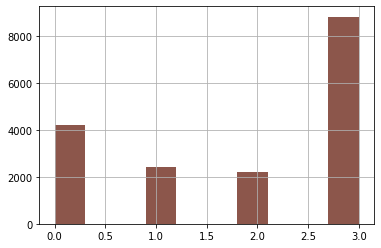

In [26]:
cat_model = Catb_Model(reduce_train, ajusted_test, features, categoricals=categoricals, params=Cat_BO.max['params'])

Found `n_estimators` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.959965	valid_1's rmse: 1.01122
[200]	training's rmse: 0.905861	valid_1's rmse: 0.995646
[300]	training's rmse: 0.871644	valid_1's rmse: 0.993165
[400]	training's rmse: 0.843209	valid_1's rmse: 0.991723
Early stopping, best iteration is:
[387]	training's rmse: 0.846623	valid_1's rmse: 0.991533
Partial score of fold 0 is: 0.5818302140764962
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.963312	valid_1's rmse: 1.00162
[200]	training's rmse: 0.909127	valid_1's rmse: 0.98298
[300]	training's rmse: 0.874739	valid_1's rmse: 0.978515
[400]	training's rmse: 0.847229	valid_1's rmse: 0.977544
[500]	training's rmse: 0.823224	valid_1's rmse: 0.977592
Early stopping, best iteration is:
[462]	training's rmse: 0.83181	valid_1's rmse: 0.97695
Partial score of fold 1 is: 0.6099229211325468
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.961

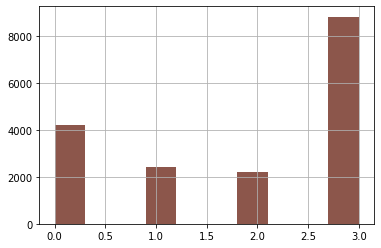

In [35]:
# solve: LightGBMError: Do not support special JSON characters in feature name.
reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
ajusted_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in ajusted_test.columns]
features = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features]

lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals, params=LGB_pramas)

[0]	train-rmse:1.85834	val-rmse:1.85888
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.13966	val-rmse:1.19493
[200]	train-rmse:0.945643	val-rmse:1.04367
[300]	train-rmse:0.891501	val-rmse:1.01163
[400]	train-rmse:0.867976	val-rmse:1.00157
[500]	train-rmse:0.855797	val-rmse:0.997316
[600]	train-rmse:0.848754	val-rmse:0.99541
[700]	train-rmse:0.844194	val-rmse:0.994463
[800]	train-rmse:0.840801	val-rmse:0.993822
[900]	train-rmse:0.838745	val-rmse:0.993601
[1000]	train-rmse:0.836371	val-rmse:0.993243
[1100]	train-rmse:0.834835	val-rmse:0.993061
[1200]	train-rmse:0.833261	val-rmse:0.99287
[1300]	train-rmse:0.832268	val-rmse:0.99282
[1400]	train-rmse:0.831195	val-rmse:0.99276
[1500]	train-rmse:0.830016	val-rmse:0.99271
[1600]	train-rmse:0.829145	val-rmse:0.992589
[1700]	train-rmse:0.828227	val-rmse:0.992532
[1800]	train-rmse:0.827454	val-rmse:0.992387
[1900]	train-rmse:0.82673	v

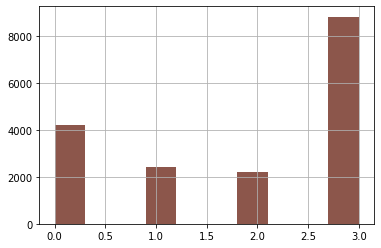

In [36]:
xgb_model = Xgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals, params=XGB_params)

In [ ]:
# cnn_model = Cnn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [ ]:
# nn_model = Nn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [ ]:
# stacking
# stacker = LinearRegression()
# S_train = np.concatenate(
#     (lgb_model.oof_pred.reshape(-1,1), \
#      xgb_model.oof_pred.reshape(-1,1), \
#      cat_model.oof_pred.reshape(-1,1)),\
#     axis=1)
# S_test = np.concatenate(
#     (lgb_model.y_pred.reshape(-1,1), \
#      xgb_model.y_pred.reshape(-1,1), \
#      cat_model.y_pred.reshape(-1,1)),\
#     axis=1)
# stacker.fit(S_train, reduce_train['accuracy_group'])
# final_pred = stacker.predict(S_test)

In [ ]:
# final_pred.shape

In [ ]:
# weights = {'lgb': 0.60, 'cat': 0.20, 'xgb': 0.20, 'nn': 0.20}

# final_pred = (lgb_model.y_pred * weights['lgb']) + (xgb_model.y_pred * weights['xgb']) + (cat_model.y_pred * weights['cat'])
# print(final_pred.shape)

In [55]:
final_pred = xgb_model.y_pred

{0: 1.0, 1: 1.0, 2: 2.0}


0    0.432
3    0.322
2    0.246
Name: accuracy_group, dtype: float64

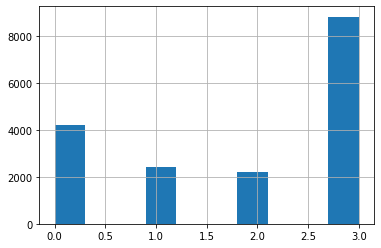

In [57]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

# lgb_model
# bound[0] = 1.18253215
# bound[1] = 1.81532098
# bound[2] = 2.17071483

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)